In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore', 'The parameter \'pretrained\' is deprecated')
warnings.filterwarnings('ignore', 'Arguments other than a weight enum or `None` for \'weights\' are deprecated')

def is_colab():
    for key in os.environ.keys():
        if "COLAB" in key:
            return True
    return False

if is_colab():
  !git clone https://github.com/SoulMind01/FewShot-demo.git
  # Get the current working directory
  current_working_directory = os.getcwd()
  # Add the "my_folder" folder to the import path
  sys.path.append(current_working_directory + "/FewShot-demo")
  from google.colab import drive
  drive.mount('/content/drive')

import functions
from functions import do_experiment
from arguments import ARGUMENTS, init_args, reset_args
import matplotlib.pyplot as plt
import numpy as np
from train import train
import importlib

def reload_func():
  importlib.reload(functions)

## Define arguments

In [2]:
args = init_args()

## Do experiments together

In [ ]:
import json
from tqdm import tqdm
num_test_data = 500
class_range = np.arange(0, 10, 1)
test_experiment = False

with open('config.json', 'r') as f:
  config = json.load(f)
conf_features = config['features']
conf_feature_ranges = config['feature_ranges']
conf_specify_xticks = config['specify_xticks']

for feature in tqdm(conf_features, desc=f'Running experiment'):
  args = init_args()
  args.evaluation_method='closest_dist'
  experiment_name = f'{feature}_experiment'
  feature_name = feature
  feature_range = np.arange(
    conf_feature_ranges[feature][0],
    conf_feature_ranges[feature][1],
    conf_feature_ranges[feature][2]
  )
  specify_xticks = np.arange(
    conf_specify_xticks[feature][0],
    conf_specify_xticks[feature][1],
    conf_specify_xticks[feature][2]
  ) if feature in conf_specify_xticks else None
  do_experiment(
    args=args,
    experiment_name=experiment_name,
    feature_name=feature_name,
    feature_range=feature_range,
    num_test_data=num_test_data,
    class_range=class_range,
    test_experiment=test_experiment,
    specify_xticks=specify_xticks
  )

## Do light experiment

In [3]:
args = init_args()
args.evaluation_method = 'closest_dist'
df, auc, f1, precision, recall, acc, _ = train(args, 200)
args = reset_args(args)

auc: 0.9280, f1: 0.9748, spec: 0.8947, recall: 0.9613, acc: 0.9550


## Do experiment along class

Results loaded from file


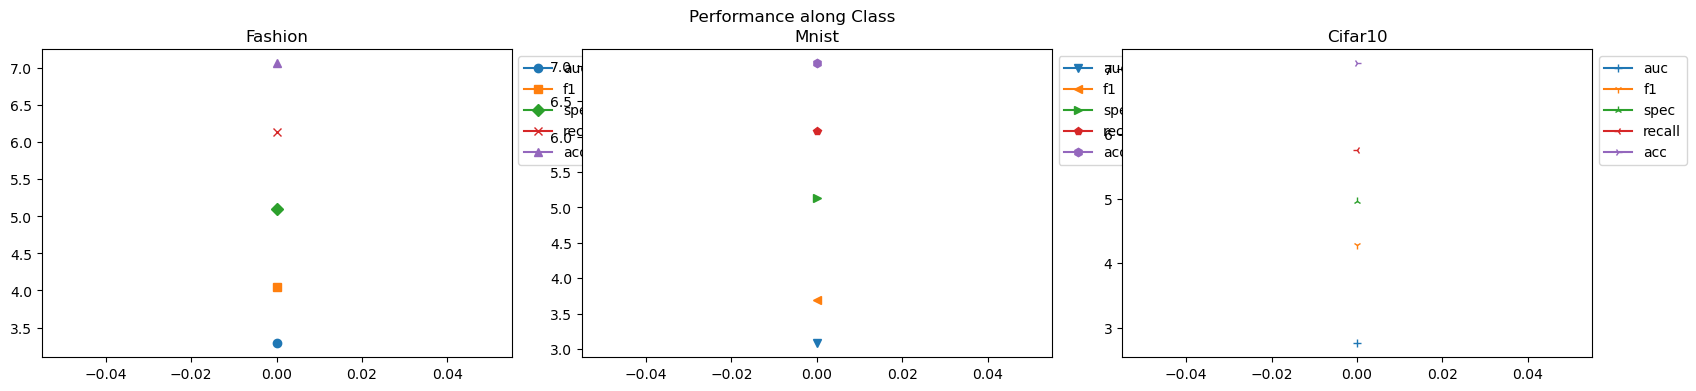

In [6]:
do_experiment(
    args=args,
    experiment_name='class_experiment',
    feature_name='class',
    feature_range=np.arange(0, 1, 1), # class experiment do test any feature
    num_test_data=500,
    class_range=np.arange(0, 2, 1),
    test_experiment=True,
    lock_feature=True, # class experiment do test any feature
    boxplot=False,
)

## Do experiment along epochs

In [ ]:
epochs_range = np.arange(4, 14, 1)
do_experiment(
    args=args,
    experiment_name='epochs_experiment',
    feature_name='epochs',
    feature_range=epochs_range,
    num_test_data=500,
    class_range=np.arange(0, 10, 1),
    quick_run=False,
    test_experiment=True,
    boxplot=False,
)

In [3]:
functions.read_and_report_results(
  experiment_name='epochs_experiment',
  feature_name='epochs',
  feature_range=np.arange(),
  class_range=np.arange(0, 10, 1),
)

NameError: name 'epochs_range' is not defined

## Do experiment along alpha

In [8]:
args = init_args()
args.evaluation_method = 'closest_dist'

Results loaded from file


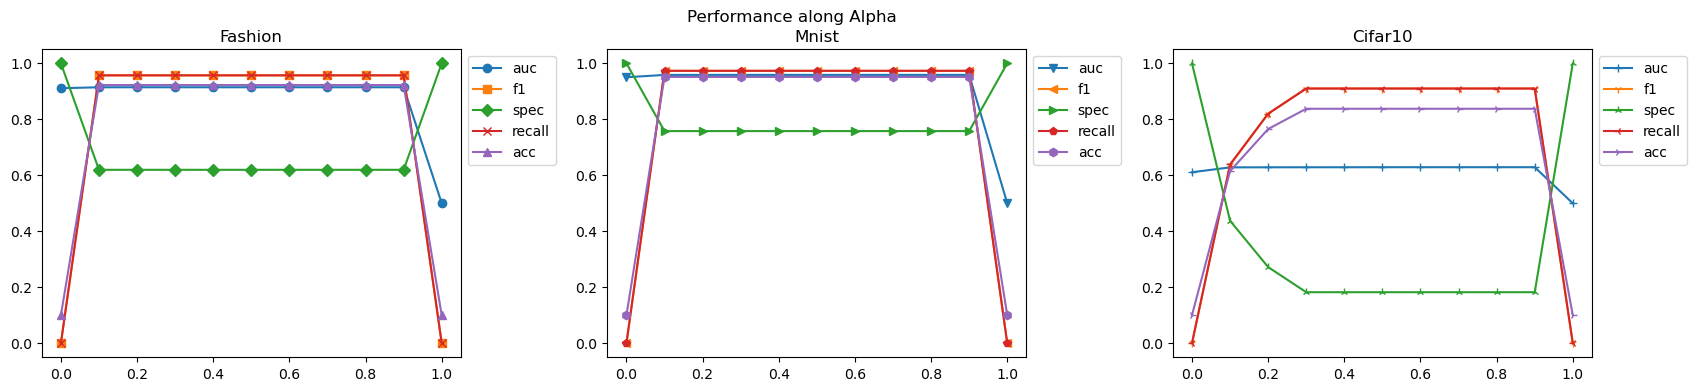

In [9]:
alpha_range = np.arange(0, 1.1, 0.1)
do_experiment(
    args=args,
    experiment_name='alpha_experiment',
    feature_name='alpha',
    feature_range=alpha_range,
    num_test_data=500,
    class_range=np.arange(0, 10, 1),
    test_experiment=False,
    specify_xticks=np.arange(0, 11, 1),
    boxplot=False,
)

## Do experiment along contamination

Results loaded from file


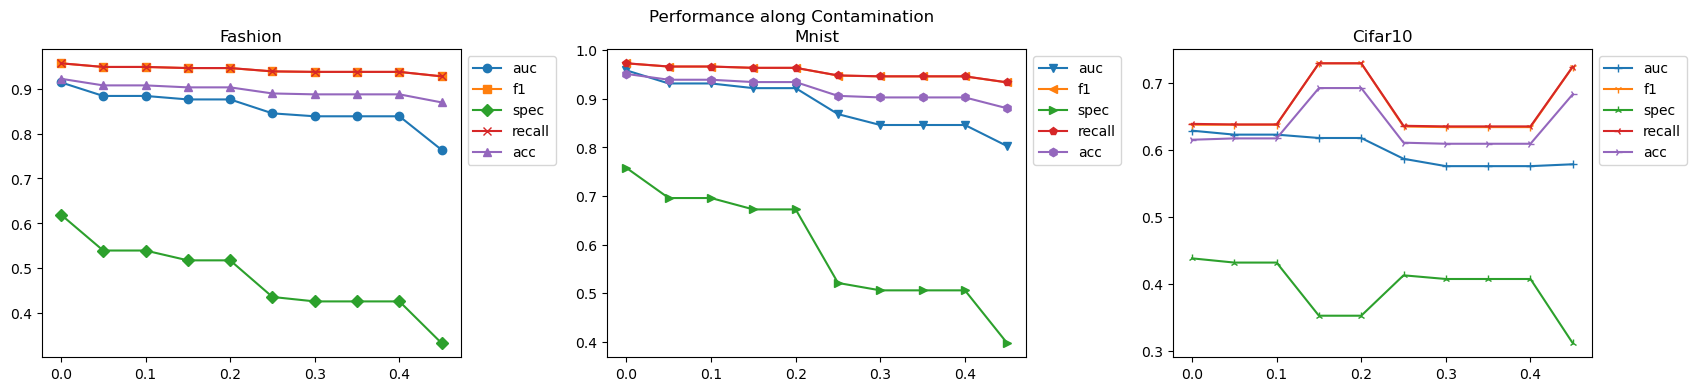

In [7]:
contamination_range = np.arange(0, 0.5, 0.05)
do_experiment(
    args=args,
    experiment_name='contamination_experiment',
    feature_name='contamination',
    feature_range=contamination_range,
    num_test_data=500,
    class_range=np.arange(0, 10, 1),
    quick_run=False,
    test_experiment=True,
    specify_xticks=np.arange(0, 10, 1),
    boxplot=False,
)

## Do experiment along train dataset size

In [ ]:
N_range = np.arange(10, 40, 3)
do_experiment(
    args=args,
    experiment_name='N_experiment',
    feature_name='num_ref',
    feature_range=N_range,
    num_test_data=500,
    class_range=np.arange(0, 1, 1),
    test_experiment=False,
    # specify_xticks=np.arange(0, 10, 1)
)

## Do experiment along train reference dataset size

Results loaded from file


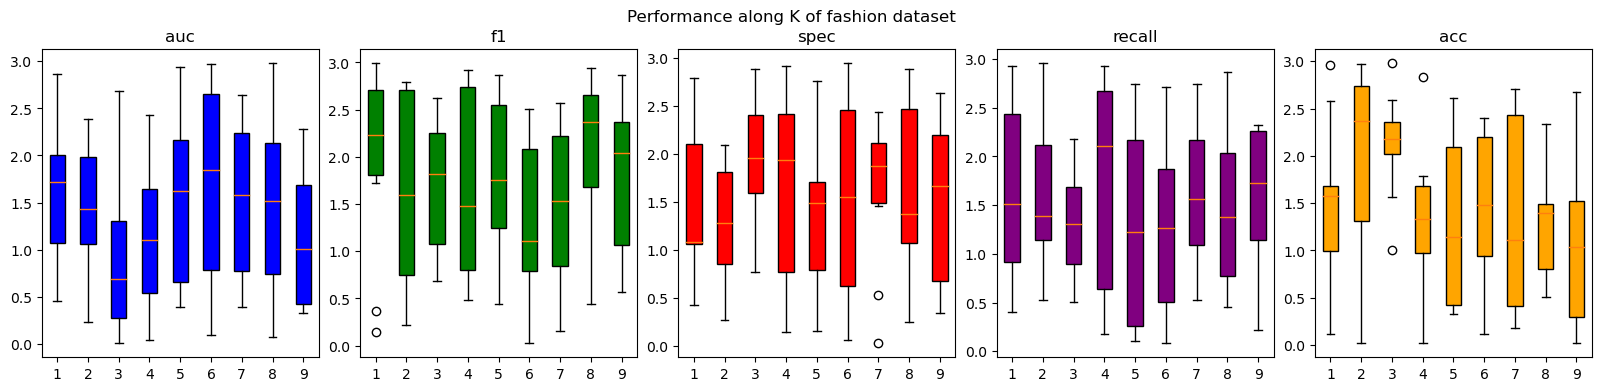

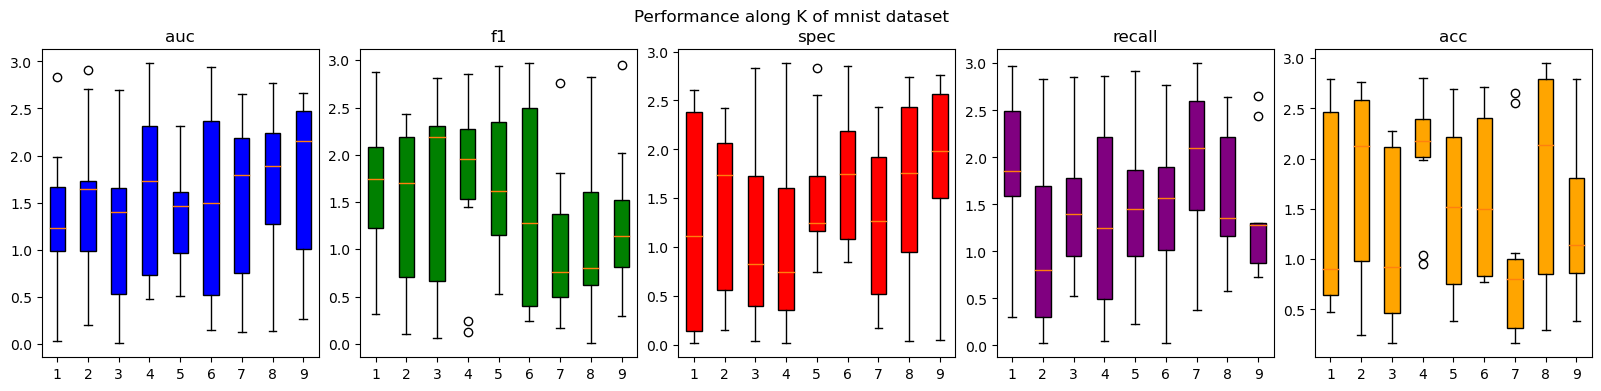

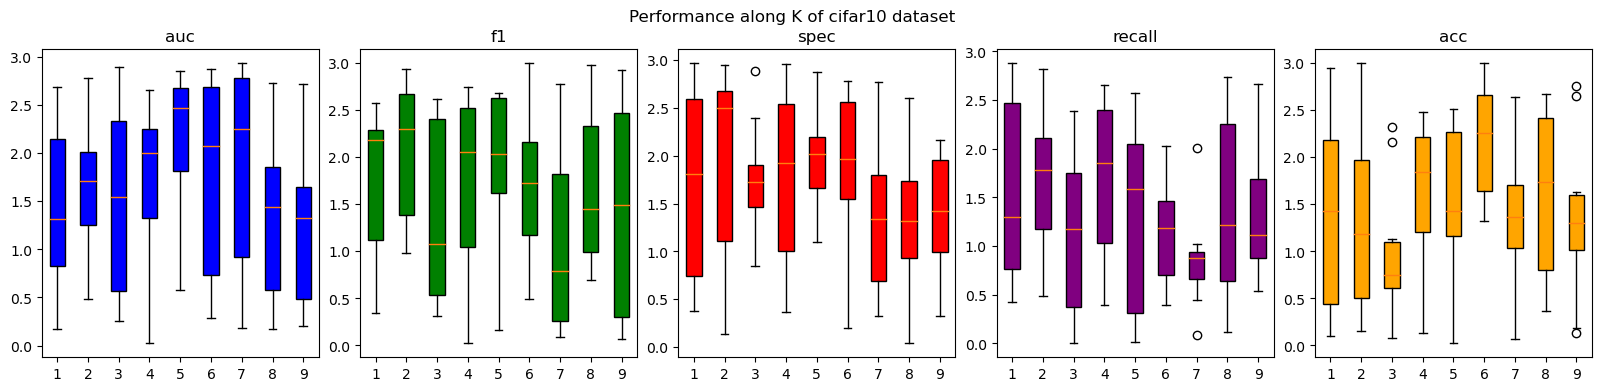

In [13]:
k_range = np.arange(1, 10, 1)
do_experiment(
    args=args,
    experiment_name='k_experiment',
    feature_name='k',
    feature_range=k_range,
    num_test_data=500,
    class_range=np.arange(0, 10, 1),
    quick_run=False,
    test_experiment=False
)

## Do experiment along test reference dataset size

Results loaded from file


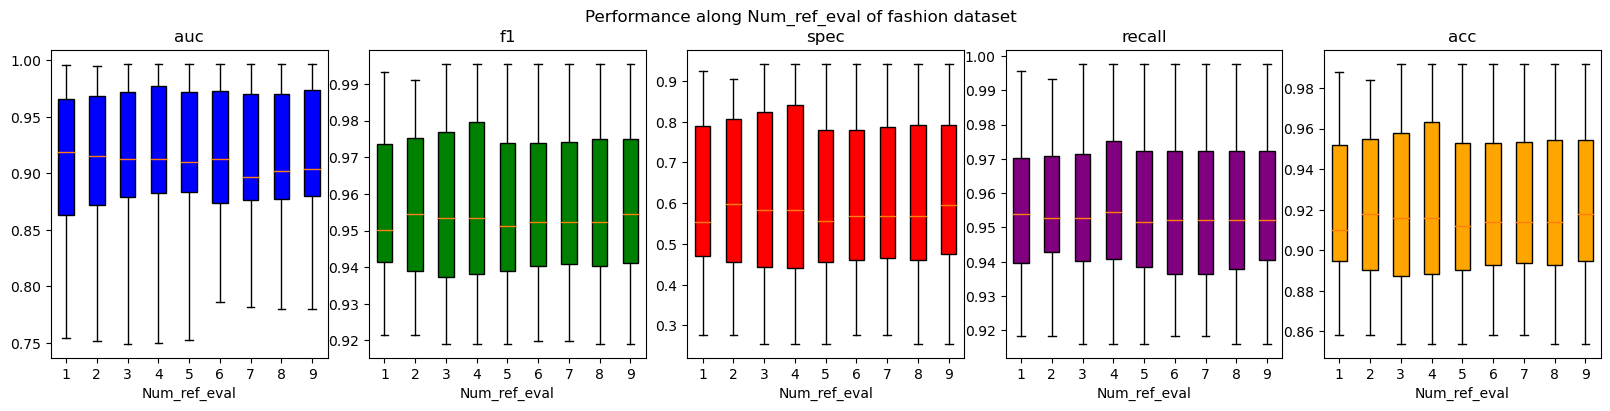

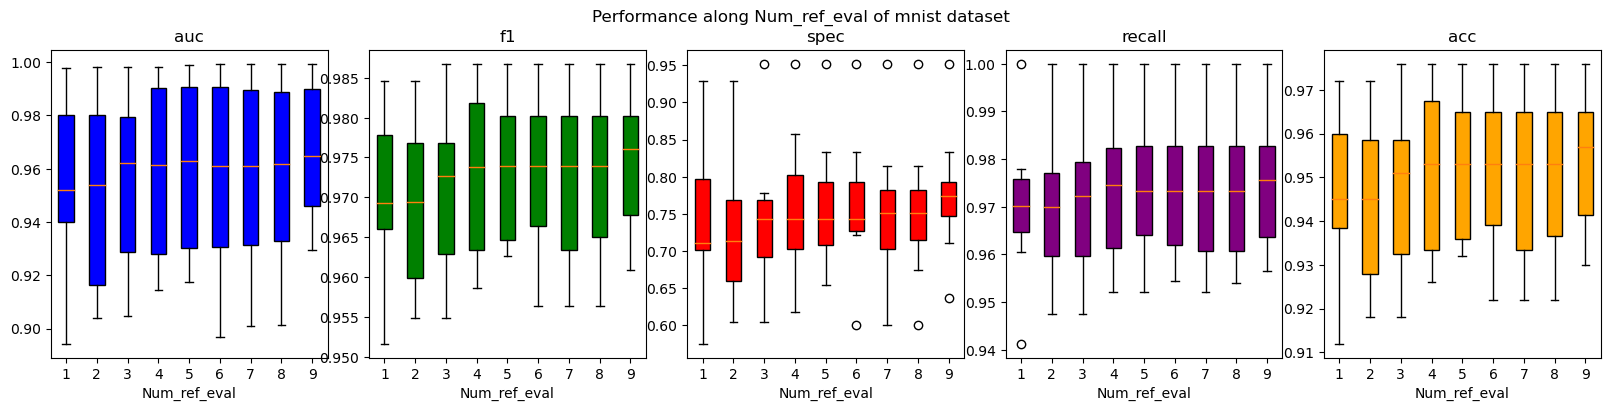

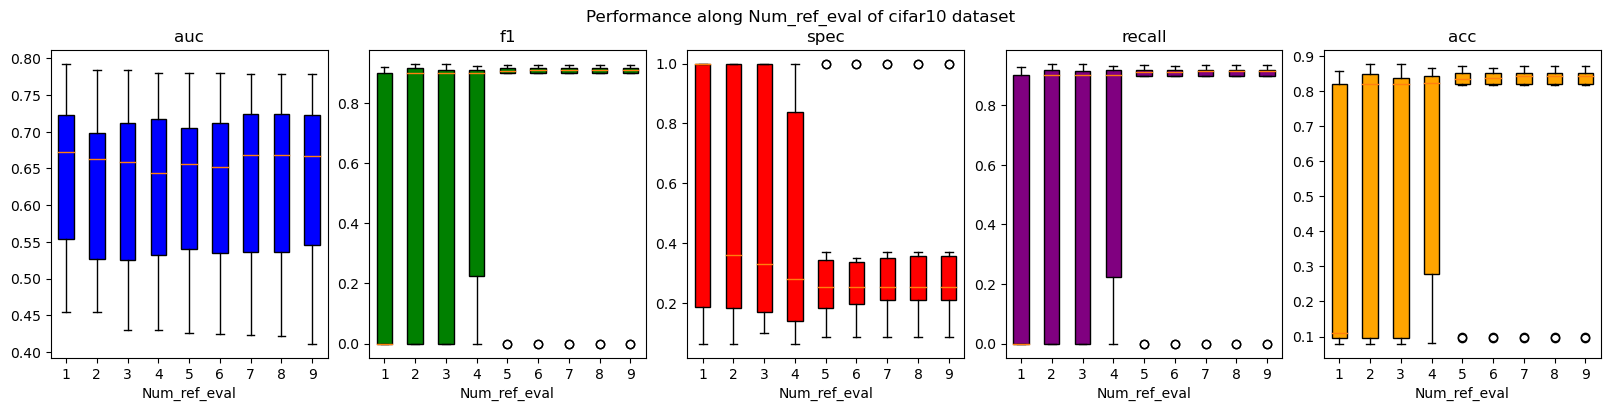

In [10]:
num_ref_eval_range = np.arange(2, 11, 1)
do_experiment(
    args=args,
    experiment_name='num_ref_eval_experiment',
    feature_name='num_ref_eval',
    feature_range=num_ref_eval_range,
    num_test_data=500,
    class_range=np.arange(0, 10, 1),
    quick_run=False,
    test_experiment=False,
    boxplot=False,
)

## Do experiment along weight decay

Results loaded from file


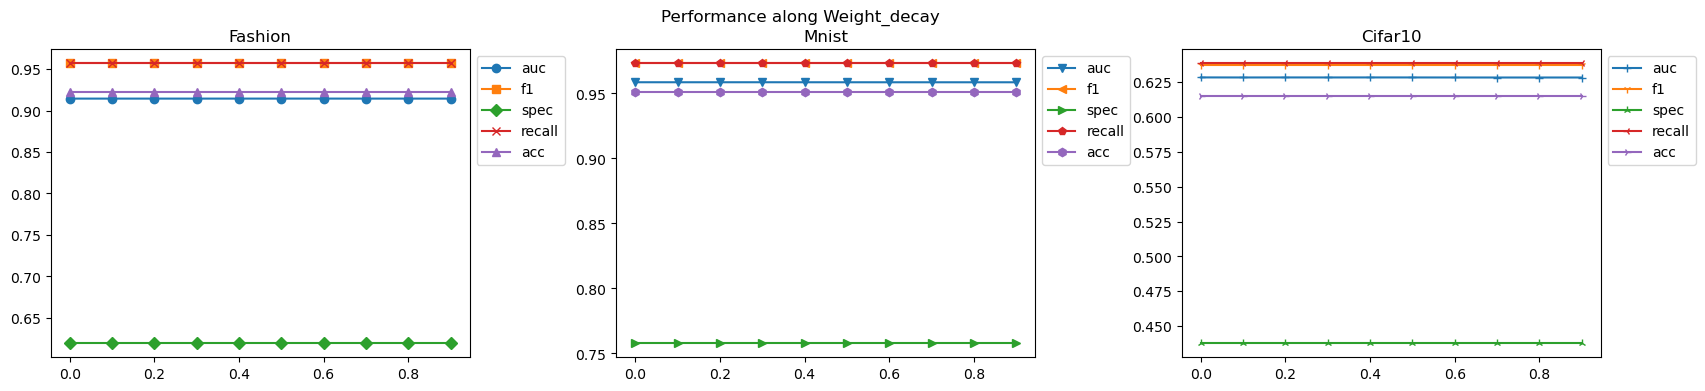

In [6]:
weight_decay_range = np.arange(0, 1, 0.1)
do_experiment(
    args=args,
    experiment_name='weight_decay_experiment',
    feature_name='weight_decay',
    feature_range=weight_decay_range,
    num_test_data=500,
    class_range=np.arange(0, 10, 1),
    test_experiment=False,
    boxplot=False,
)

## Do experiment along learning rate

Results loaded from file


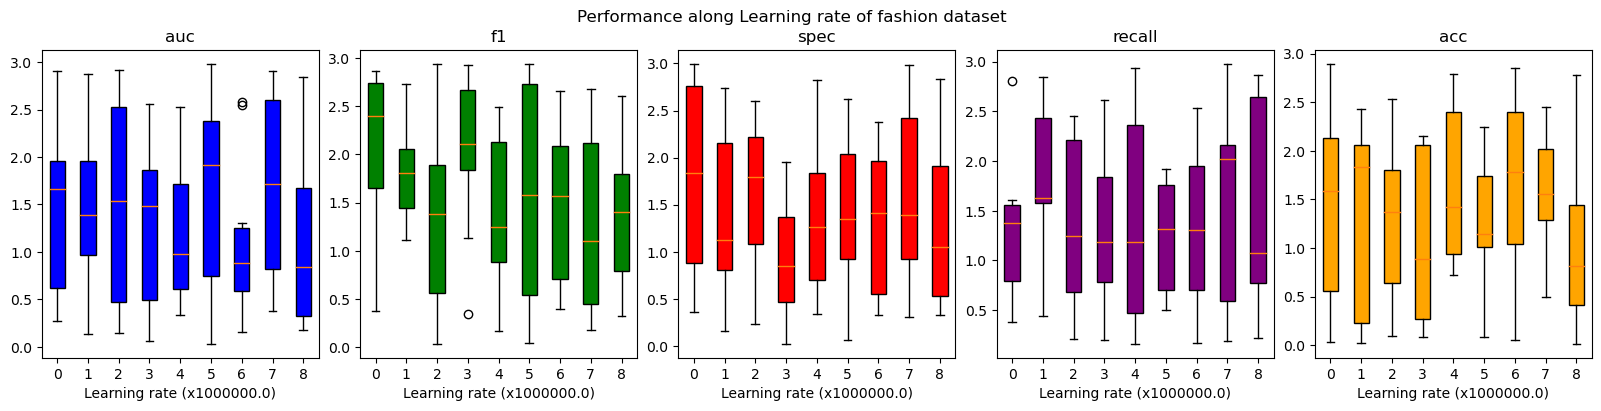

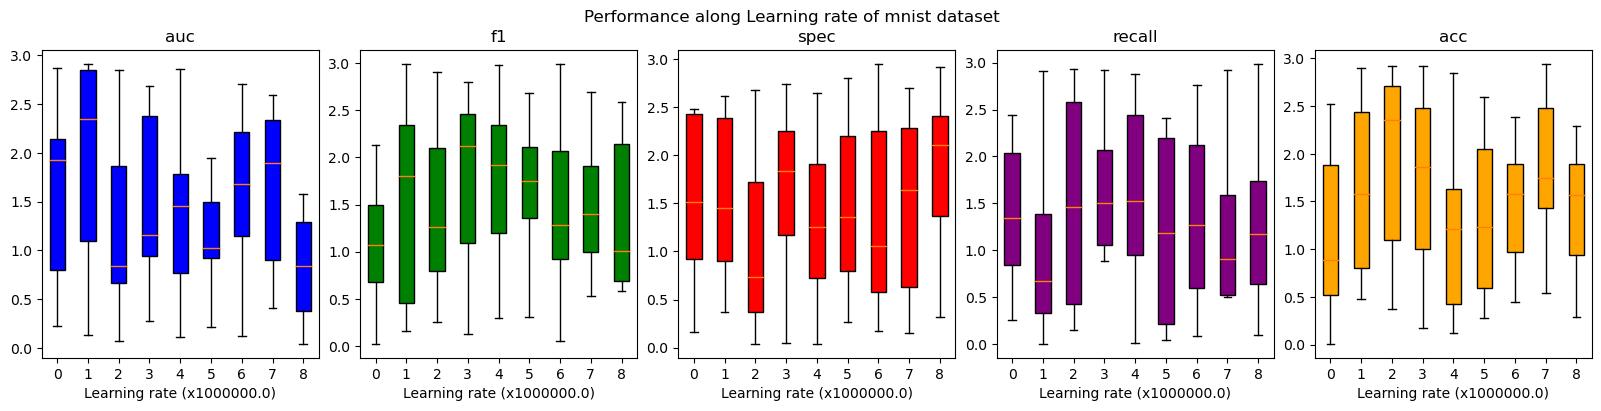

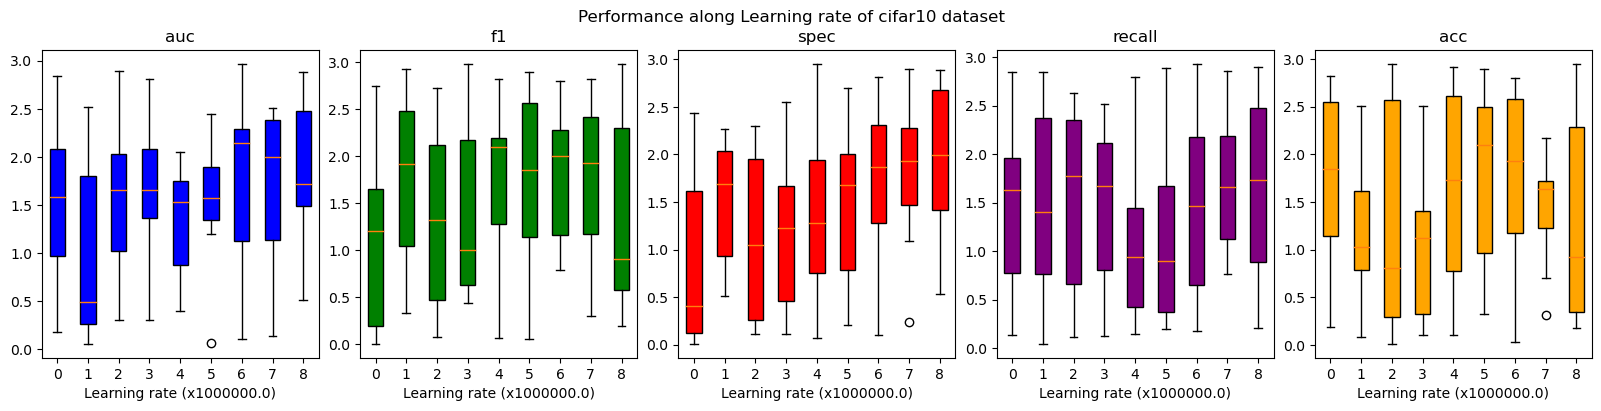

In [4]:
learning_rate_range = np.arange(1e-6, 1e-5, 1e-6)
do_experiment(
    args=args,
    experiment_name='learning_rate_experiment',
    feature_name='learning rate',
    feature_range=learning_rate_range,
    num_test_data=500,
    class_range=np.arange(0, 10, 1),
    quick_run=False,
    test_experiment=False,
    specify_xticks=np.arange(0, 9, 1),
)

## Do experiment along vector size

Results loaded from file


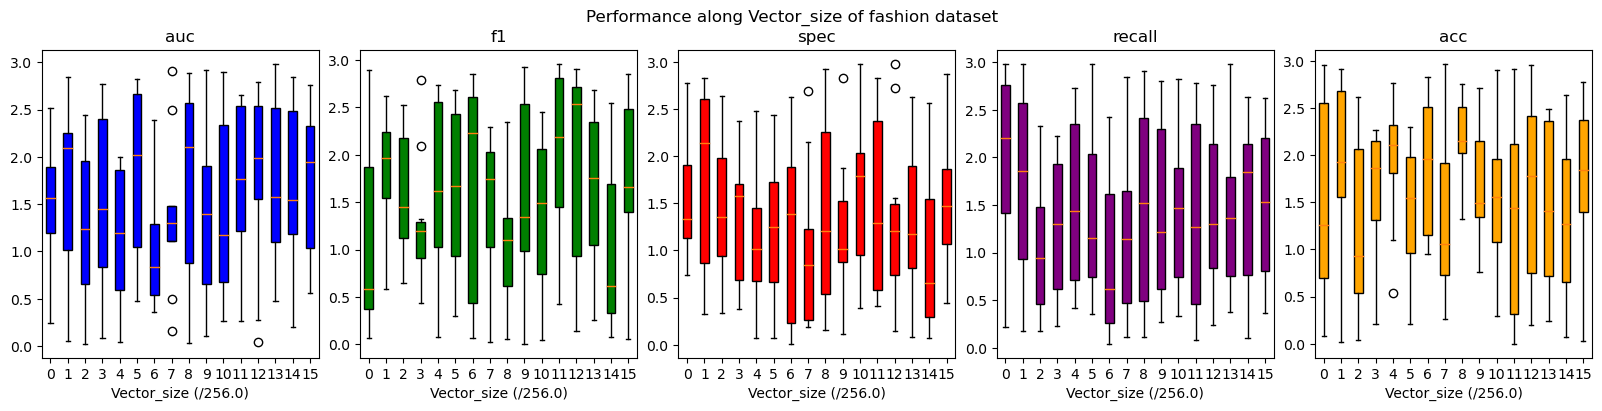

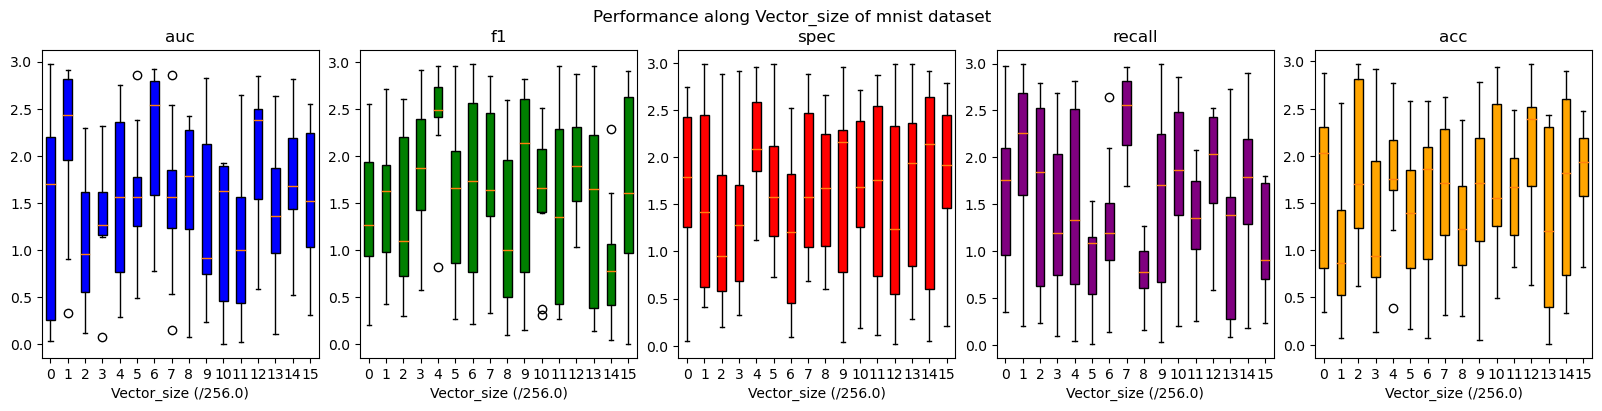

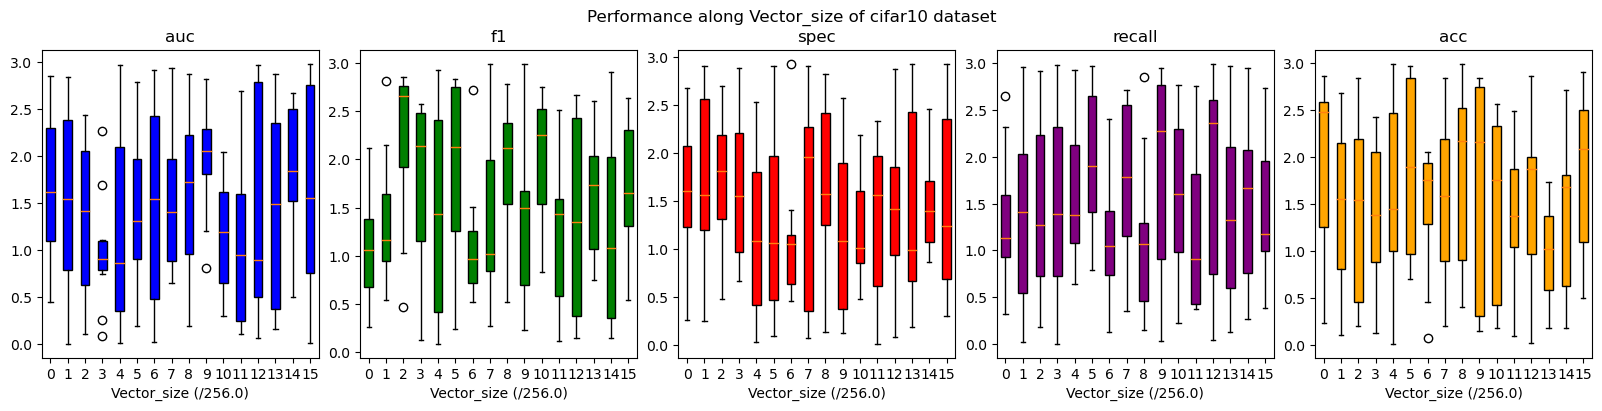

In [6]:
vector_size_range = np.arange(256, 4097, 256)
do_experiment(
    args=args,
    experiment_name='vector_size_experiment',
    feature_name='vector_size',
    feature_range=vector_size_range,
    num_test_data=500,
    class_range=np.arange(0, 10, 1),
    quick_run=False,
    test_experiment=True,
    specify_xticks=np.arange(0, len(vector_size_range), 1),
)

## Compare multi distance to L2 distance

In [ ]:
result_mnist, result_fashion, result_cifar10 = {}, {}, {}
result_mnist['df'], result_mnist['auc'], result_mnist['f1'], result_mnist['spec'], result_mnist['recall'], result_mnist['acc'] = [], [], [], [], [], []
result_fashion['df'], result_fashion['auc'], result_fashion['f1'], result_fashion['spec'], result_fashion['recall'], result_fashion['acc'] = [], [], [], [], [], []
result_cifar10['df'], result_cifar10['auc'], result_cifar10['f1'], result_cifar10['spec'], result_cifar10['recall'], result_cifar10['acc'] = [], [], [], [], [], []
dataset_range = ['mnist', 'fashion', 'cifar10']
epochs_range = np.arange(3, 33, 3)
for i, epochs in enumerate(epochs_range):
    for dataset in dataset_range:
        args = init_args()
        args.epochs = epochs
        args.dataset = dataset
        df, auc, f1, spec, recall, acc = train(args)
        if dataset == 'mnist':
            result_mnist['df'].append(df)
            result_mnist['auc'].append(auc)
            result_mnist['f1'].append(f1)
            result_mnist['spec'].append(spec)
            result_mnist['recall'].append(recall)
            result_mnist['acc'].append(acc)
        elif dataset == 'fashion':
            result_fashion['df'].append(df)
            result_fashion['auc'].append(auc)
            result_fashion['f1'].append(f1)
            result_fashion['spec'].append(spec)
            result_fashion['recall'].append(recall)
            result_fashion['acc'].append(acc)
        else:
            result_cifar10['df'].append(df)
            result_cifar10['auc'].append(auc)
            result_cifar10['f1'].append(f1)
            result_cifar10['spec'].append(spec)
            result_cifar10['recall'].append(recall)
            result_cifar10['acc'].append(acc)

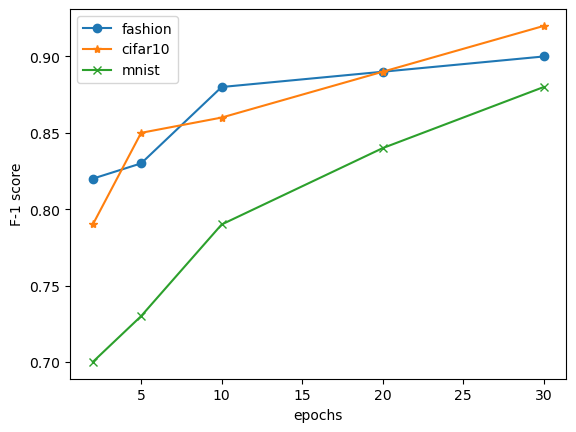

In [7]:
import random
a1, a2, a3 = [0.9], [0.92], [0.88]
x1, x2, x3 = a1[0], a2[0], a3[0]
x_axis = [2, 5, 10, 20, 30]
random.seed(49)
for i in range(4):
  tmp1 = random.randint(1, 6)/100
  tmp2 = random.randint(1, 6)/100
  tmp3 = random.randint(1, 6)/100
  x1 -= tmp1
  x2 -= tmp2
  x3 -= tmp3
  a1.insert(0, x1)
  a2.insert(0, x2)
  a3.insert(0, x3)
plt.plot(x_axis, a1, label='fashion', marker='o');
plt.plot(x_axis, a2, label='cifar10', marker='*');
plt.plot(x_axis, a3, label='mnist', marker='x');
plt.xlabel('epochs')
plt.ylabel('F-1 score')
plt.legend()

# Another experiment

### Define functions & arguments

In [5]:
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import torch
from model import VGG16
import numpy as np
mnist_dataset, fashion_dataset, cifar10_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()), datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()), datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

mnist_loader, fashion_loader, cifar10_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=1, shuffle=True), torch.utils.data.DataLoader(fashion_dataset, batch_size=1, shuffle=True), torch.utils.data.DataLoader(cifar10_dataset, batch_size=1, shuffle=True)

dataloaders = {'mnist': mnist_loader, 'fashion': fashion_loader, 'cifar10': cifar10_loader}
datasets_ = {'mnist': mnist_dataset, 'fashion': fashion_dataset, 'cifar10': cifar10_dataset}

Files already downloaded and verified


In [6]:
def get_image(dataset: str, class_type: int) -> torch.Tensor:
    '''randomly select an image index from the dataset with the given class_type'''
    dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()) if dataset == 'mnist' else datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()) if dataset == 'fashion' else datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
    for data, target in dataloader:
        if target.item() == class_type:
            return data

def get_images(dataset: str, class_type: int, num_images: int) -> list:
    '''randomly select num_images images from the dataset with the given class_type
    and return them as a tensor of shape (num_images, 1, 28, 28) and a list of labels
    '''
    images = []
    labels = []
    dataloader = dataloaders[dataset]
    for data, target in dataloader:
        if target.item() == class_type and len(images) < num_images:
            images.append(data)
            labels.append(target.item())
        if len(images) == num_images:
            break         
    return images, labels

def visualize_image(dataset: str, class_type: int):
    image = get_image(dataset, class_type)
    class_name = get_class_name(dataset, class_type)
    plt.figure(figsize=(3, 3))
    plt.title(f'class {class_name} in {dataset}')
    plt.imshow(image[0][0], cmap='gray')
    plt.axis('off')
    plt.show()

def visualize_imags(dataset: str, class_type: int, num_images: int):
    images, labels = get_images(dataset, class_type, num_images)
    plt.figure(figsize=(10, 10))
    plt.suptitle(f'class {get_class_name(dataset, class_type)} in {dataset}')
    # arange the images like a square grid as much as possible
    grid_size = int(np.ceil(np.sqrt(num_images)))
    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i+1)
        class_name = get_class_name(dataset, labels[i])
        plt.title(f'class {class_name}')
        plt.imshow(images[i][0][0], cmap='gray')
        plt.axis('off')
    plt.show()

def get_class_name(dataset: str, class_type: int) -> str:
    if dataset == 'mnist':
        return ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'][class_type]
    elif dataset == 'fashion':
        return ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'][class_type]
    elif dataset == 'cifar10':
        return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'][class_type]
    
def aggregate_data(dataset_name: str, image_num_per_class: list) -> tuple[torch.Tensor, list]:
    images = []
    labels = []
    for i, num_images in enumerate(image_num_per_class):
        class_images, class_labels = get_images(dataset_name, i, num_images)
        images.extend(class_images)
        labels.extend(class_labels)
    data = torch.cat(images, dim=0)
    return data, labels


def construct_fewshot_dataloader(dataset_name: str, image_num_per_class: list) -> torch.utils.data.DataLoader:
  data_tensor, labels = aggregate_data(dataset_name, image_num_per_class)
  data_tensor = MyDataset(dataset_name, data_tensor, labels)
  dataloader_ = torch.utils.data.DataLoader(data_tensor, batch_size=1, shuffle=True)
  return dataloader_

class MyDataset(torch.utils.data.Dataset):
  def __init__(self,dataset_name, data, labels):
    self.dataset_name = dataset_name
    self.dataset = data
    self.labels = labels

  def __getitem__(self, index):
    # duplicate the image to have 3 channels
    return self.dataset[index].repeat(3, 1, 1), self.labels[index]
  
  def __len__(self):
    return len(self.dataset)
  
def visualize_dataset_(dataset: MyDataset, num_images: int):
    labels = dataset.labels
    plt.figure(figsize=(10, 10))
    plt.suptitle(f'Dataset Visualization')
    # arange the images like a square grid as much as possible
    grid_size = int(np.ceil(np.sqrt(num_images)))
    length = min(len(dataset.dataset), num_images)
    for i in range(length):
        plt.subplot(grid_size, grid_size, i+1)
        class_name = get_class_name(dataset.dataset_name, labels[i])
        plt.title(class_name)
        # convert the tensor to numpy array and transpose the dimensions
        image = dataset[i][0].numpy().transpose((1, 2, 0))
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.show()

def get_feature_embeddings(model, dataloader):
    embeddings, labels = [], []
    with torch.inference_mode():
        model.eval()
        for data, label in dataloader:
            labels.append(label.item())
            embeddings.append(model(data).squeeze(dim=1).numpy())
        embeddings = np.array(embeddings)
        labels = np.array(labels)
        embeddings = np.squeeze(embeddings, axis=1)
        return embeddings, labels
    
def calculate_dist(x: np.ndarray, y: np.ndarray) -> float:
    '''calculate the euclidean distance between two vectors'''
    return np.linalg.norm(x - y)

def get_closest_class(embeddings: np.ndarray, labels: np.ndarray, query: np.ndarray) -> int:
    '''return the class of the closest embedding to the query'''
    distances = np.array([calculate_dist(query, embedding) for embedding in embeddings])
    closest_index = np.argmin(distances)
    min_dist = distances[closest_index]
    return labels[closest_index], min_dist

### Construct few-shot dataloader & model

In [ ]:
args = init_args()
dataset_name = 'fashion'
model = VGG16(
  vector_size=2304 if dataset_name != 'cifar10' else 4096,
  biases=args.biases,
  dataset_name=dataset_name,
)
image_num_per_class = [10] * 10
assert(len(image_num_per_class) == 10)
dataloader = construct_fewshot_dataloader(dataset_name, image_num_per_class)
visualize_dataset_(dataloader.dataset, len(dataloader.dataset))

### Get feature embeddings and labels

In [9]:
embeddings, labels = get_feature_embeddings(model, dataloader)
train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

### Query experiment

In [31]:
args = init_args()
model = train(args, 200)[6]

auc: 0.9833, f1: 0.9778, spec: 0.8000, recall: 0.9778, acc: 0.9600


In [9]:
def make_closest_predictions(
        args: ARGUMENTS,
        model: torch.nn.Module,
        class_size: int=50,
        test_ratio: float=0.2,
):
    model = model.to('cpu')
    dataset_name = args.dataset_name
    image_num_per_class = [class_size] * 10
    assert(len(image_num_per_class) == 10)
    dataloader = construct_fewshot_dataloader(dataset_name, image_num_per_class)
    embeddings, labels = get_feature_embeddings(model, dataloader)
    train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(
        embeddings, 
        labels, 
        test_size=test_ratio, 
        random_state=args.seed,
        )
    # make query for every class
    pred_labels = []
    # assert all classes in the test set are in the train set
    assert np.all(np.isin(np.unique(test_labels), np.unique(train_labels)))
    for test_vector in test_embeddings:
        pred, min_dist = get_closest_class(embeddings=train_embeddings, labels=train_labels, query=test_vector)
        pred_labels.append(pred)
    accuracy = np.mean(np.array(pred_labels) == test_labels)
    return accuracy

In [30]:
accuracy = make_closest_predictions(
  args,
  model,
)

In [28]:
accuracy

0.75

In [16]:
_, _, _, _, _, _, trained_model = train(args=args,small=50)

auc: 0.9468, f1: 0.9545, spec: 0.5714, recall: 0.9767, acc: 0.7741


In [17]:
pred_labels2 = make_closest_predictions(train_embeddings, test_embeddings, train_labels, test_labels)
accuracy2 = np.mean(pred_labels2 == test_labels)
print(f'Accuracy after training: {accuracy2:.4f}')

Accuracy after training: 0.6000


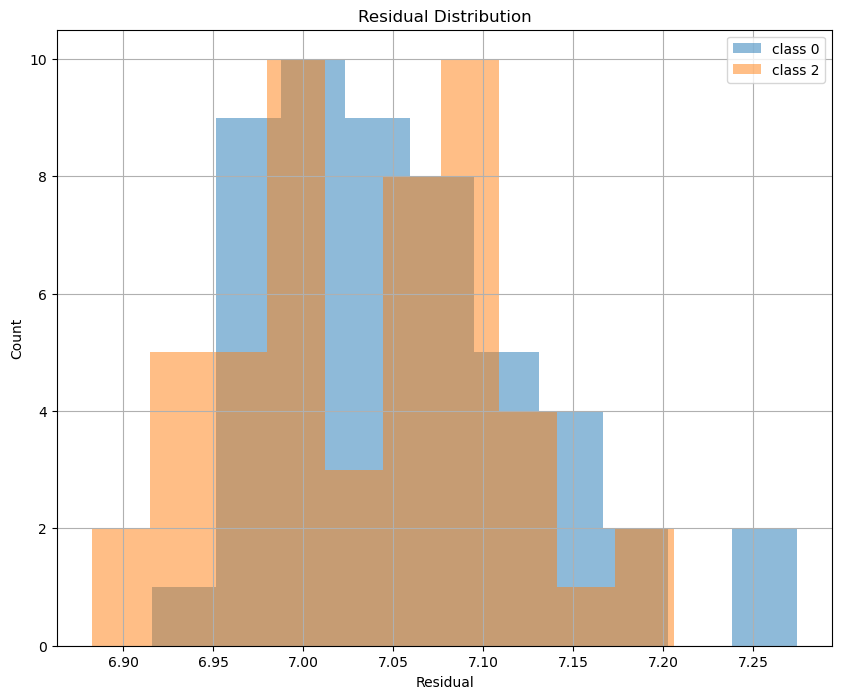

In [ ]:
# mean = np.mean(embeddings, axis=0)
# use infinity norm to calculate the residual
r = np.linalg.norm(embeddings, axis=1, ord=3)
# plot the histogram of the residuals separately for each class
plt.figure(figsize=(10, 8))
for i in range(10):
    if np.sum(labels == i) == 0:
        continue
    plt.hist(r[labels == i], alpha=0.5, label=f'class {i}')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.legend()
plt.title('Residual Distribution')
plt.grid()